<a href="https://colab.research.google.com/github/istiak9999/Malicious-url-classification-using-1d-cnn-and-Bidirectional-Lstm/blob/main/malicious_url_with_1d_CNN_%26_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 14 kB/s 
     |████████████████████████████████| 6.0 MB 55.1 MB/s 
     |████████████████████████████████| 439 kB 63.4 MB/s 
     |████████████████████████████████| 1.7 MB 15.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [ ]:
!nvidia-smi

Wed Dec  7 10:55:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install additional library
!pip install tldextract -q

# import library
import numpy as np
import pandas as pd
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse
import tldextract

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

# set random seed
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# other setup
%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 50)
pio.templates.default = "presentation"
pd.options.plotting.backend = "plotly"
deprecation._PRINT_DEPRECATION_WARNINGS = False

     |████████████████████████████████| 93 kB 1.7 MB/s 


#load data

In [ ]:
# load data
data = pd.read_csv('/content/drive/MyDrive/Machine Learning Dataset/Malicious url researchpaper data/data for 1d cnn .csv')
data.head()

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [ ]:
data.shape

(420464, 2)

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=0)

In [ ]:
def parsed_url(url):
    # extract subdomain, domain, and domain suffix from url
    # if item == '', fill with '<empty>'
    subdomain, domain, domain_suffix = ('<empty>' if extracted == '' else extracted for extracted in tldextract.extract(url))   
    
    return [subdomain, domain, domain_suffix]

def extract_url(data):
    # parsed url
    extract_url_data = [parsed_url(url) for url in data['url']]
    extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain', 'domain_suffix'])
    
    # concat extracted feature with main data
    data = data.reset_index(drop=True)
    data = pd.concat([data, extract_url_data], axis=1)
    
    return data

def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')
    
    # scale log base 10
    data['values'] = np.log10(data['values'])
    
    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())
    
    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)
    
    return data
def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')
    
    # scale log base 10
    data['values'] = np.log10(data['values'])
    
    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())
    
    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)
    
    return data
def plot(data, n_group, title):
    data = get_frequent_group(data, n_group)
    fig = px.bar(data, x=data.columns[1], y='values', color='label')
    fig.update_layout(title=title)
    fig.show()



In [ ]:
# extract url
data = extract_url(data)
train_data = extract_url(train_data)
val_data = extract_url(val_data)

In [ ]:
data.head()

,url,label,subdomain,domain,domain_suffix
0,diaryofagameaddict.com,bad,<empty>,diaryofagameaddict,com
1,espdesign.com.au,bad,<empty>,espdesign,com.au
2,iamagameaddict.com,bad,<empty>,iamagameaddict,com
3,kalantzis.net,bad,<empty>,kalantzis,net
4,slightlyoffcenter.net,bad,<empty>,slightlyoffcenter,net


In [ ]:
data.head()

,url,label,subdomain,domain,domain_suffix
0,diaryofagameaddict.com,bad,<empty>,diaryofagameaddict,com
1,espdesign.com.au,bad,<empty>,espdesign,com.au
2,iamagameaddict.com,bad,<empty>,iamagameaddict,com
3,kalantzis.net,bad,<empty>,kalantzis,net
4,slightlyoffcenter.net,bad,<empty>,slightlyoffcenter,net


In [ ]:
data.columns

Index(['url', 'label', 'subdomain', 'domain', 'domain_suffix'], dtype='object')

In [ ]:
fig = go.Figure([go.Pie(labels=['Good', 'Bad'], values=data.label.value_counts())])
fig.update_layout(title='Percentage of Class (Good vs. Bad)')
fig.show()

In [ ]:
fig = go.Figure([go.Bar(
    x=['domain', 'Subdomain', 'Domain Suffix'], 
    y = [data.domain.nunique(), data.subdomain.nunique(), data.domain_suffix.nunique()]
)])
fig.show()

In [ ]:
plot(
    data=data.groupby('label')['domain'], 
    n_group=20, 
    title='Top 20 Domains Grouped By Labels (Logarithmic Scale)'
)

In [ ]:
data.shape

(420464, 5)

The next step we need to do tokenization on the url so that it can be used as input to the CNN model.

In [ ]:
tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)

# fit only on training data
tokenizer.fit_on_texts(train_data['url'])
n_char = len(tokenizer.word_index.keys())

train_seq = tokenizer.texts_to_sequences(train_data['url'])
val_seq = tokenizer.texts_to_sequences(val_data['url'])

print('Before tokenization: ')
print(train_data.iloc[0]['url'])
print('\nAfter tokenization: ')
print(train_seq[0])

Before tokenization: 
mister-ed.com/welcome/file/update/rbc/login.php

After tokenization: 
[12, 5, 9, 7, 2, 10, 15, 2, 16, 13, 8, 3, 12, 6, 26, 2, 14, 8, 3, 12, 2, 6, 25, 5, 14, 2, 6, 19, 17, 16, 4, 7, 2, 6, 10, 21, 8, 6, 14, 3, 20, 5, 11, 13, 17, 18, 17]


Each url has a different length, therefore padding is needed to equalize each url length. Next step we will do padding on url that we already have tokenize

In [ ]:
print(n_char)

160


In [ ]:
sequence_length = np.array([len(i) for i in train_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Before padding: \n {train_seq[0]}')
train_seq = pad_sequences(train_seq, padding='post', maxlen=sequence_length)
val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)
print(f'After padding: \n {train_seq[0]}')

Before padding: 
 [12, 5, 9, 7, 2, 10, 15, 2, 16, 13, 8, 3, 12, 6, 26, 2, 14, 8, 3, 12, 2, 6, 25, 5, 14, 2, 6, 19, 17, 16, 4, 7, 2, 6, 10, 21, 8, 6, 14, 3, 20, 5, 11, 13, 17, 18, 17]
After padding: 
 [12  5  9  7  2 10 15  2 16 13  8  3 12  6 26  2 14  8  3 12  2  6 25  5
 14  2  6 19 17 16  4  7  2  6 10 21  8  6 14  3 20  5 11 13 17 18 17  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
print(sequence_length,n_char)

161 160


We will also encode subdomain, domain, suffix domains and label into numerical variables

In [ ]:
unique_value = {}
for feature in ['subdomain', 'domain', 'domain_suffix']:
    # get unique value
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}
    
    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1
    
    # count unique value
    unique_value[feature] = label_index['<unknown>']
    
    # encode
    train_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in train_data.loc[:, feature]]
    val_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in val_data.loc[:, feature]]
    
train_data.head()


,url,label,subdomain,domain,domain_suffix
0,mister-ed.com/welcome/file/update/rbc/login.php,bad,0,0,0
1,ip-23-229-147-12.ip.secureserver.net/public/fi...,bad,1,1,1
2,facebok-info.com/unitedkingdom/log.php,bad,0,2,0
3,independent.co.uk/news/obituaries/john-gross-g...,good,0,3,2
4,facebook.com/geoffrey.gray,good,0,4,0


In [ ]:
unique_value

{'subdomain': 23249, 'domain': 98235, 'domain_suffix': 661}

encode target value

In [ ]:
train_data.columns

Index(['url', 'label', 'subdomain', 'domain', 'domain_suffix'], dtype='object')

unique_value2 = {}
for feature in ['count-',
       'count@', 'count?', 'count%', 'count=', 'count-http', 'count-https',
       'count-www', 'count-digits', 'count-letters', 'count_dir']:
    # get unique value
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}
    
    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1
    
    # count unique value
    unique_value[feature] = label_index['<unknown>']

In [ ]:
print(unique_value)

{'subdomain': 23249, 'domain': 98235, 'domain_suffix': 661}


encoding label

In [ ]:
for data in [train_data, val_data]:
    data.loc[:, 'label'] = [0 if i == 'good' else 1 for i in data.loc[:, 'label']]
    
train_data.head()

,url,label,subdomain,domain,domain_suffix
0,mister-ed.com/welcome/file/update/rbc/login.php,1,0,0,0
1,ip-23-229-147-12.ip.secureserver.net/public/fi...,1,1,1,1
2,facebok-info.com/unitedkingdom/log.php,1,0,2,0
3,independent.co.uk/news/obituaries/john-gross-g...,0,0,3,2
4,facebook.com/geoffrey.gray,0,0,4,0


In [ ]:
# create train data
train_x = [train_seq, train_data['subdomain'], train_data['domain'], train_data['domain_suffix']]
train_y = train_data['label'].values
val_x=[val_seq, val_data['subdomain'], val_data['domain'], val_data['domain_suffix']]
val_y=val_data['label'].values

In [ ]:
print(sequence_length, n_char, unique_value,)

161 160 {'subdomain': 23249, 'domain': 98235, 'domain_suffix': 661}


#create the CNN model 

In [ ]:
from keras.layers import LSTM

In [ ]:
def convolution_block(x):
    conv_3_layer = layers.Conv1D(64, 3, padding='same', activation='elu')(x)
    conv_5_layer = layers.Conv1D(64, 5, padding='same', activation='elu')(x)
    conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer])
    conv_layer=layers.MaxPool1D(pool_size=2)(conv_layer)
    conv_layer=layers.Bidirectional(LSTM(100,return_sequences=True))(conv_layer)
    conv_layer = layers.Flatten()(conv_layer)

    return conv_layer

def embedding_block(unique_value, size, name):
    input_layer = layers.Input(shape=(1,), name=name + '_input')
    embedding_layer = layers.Embedding(unique_value, size, input_length=1)(input_layer)
    return input_layer, embedding_layer

def create_model(sequence_length, n_char, unique_value2):
    input_layer = []
    
    # sequence input layer
    sequence_input_layer = layers.Input(shape=(sequence_length,), name='url_input')
    input_layer.append(sequence_input_layer)
    
    # convolution block
    char_embedding = layers.Embedding(n_char + 1, 32, input_length=sequence_length)(sequence_input_layer)
    conv_layer = convolution_block(char_embedding)
    
    # entity embedding
    entity_embedding = []
    for key, n in unique_value.items():
        size = 4
        input_l, embedding_l = embedding_block(n + 1, size, key)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)
      
    # concat all layer
    fc_layer = layers.concatenate([conv_layer, *entity_embedding])
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)
    
    # dense layer
    fc_layer = layers.Dense(128, activation='tanh')(fc_layer)
    fc_layer = layers.Dropout(rate=0.2)(fc_layer)
    
    # output layer
    output_layer = layers.Dense(1, activation='sigmoid')(fc_layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
    return model

# reset session
backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# create model
model = create_model(sequence_length, n_char, unique_value)



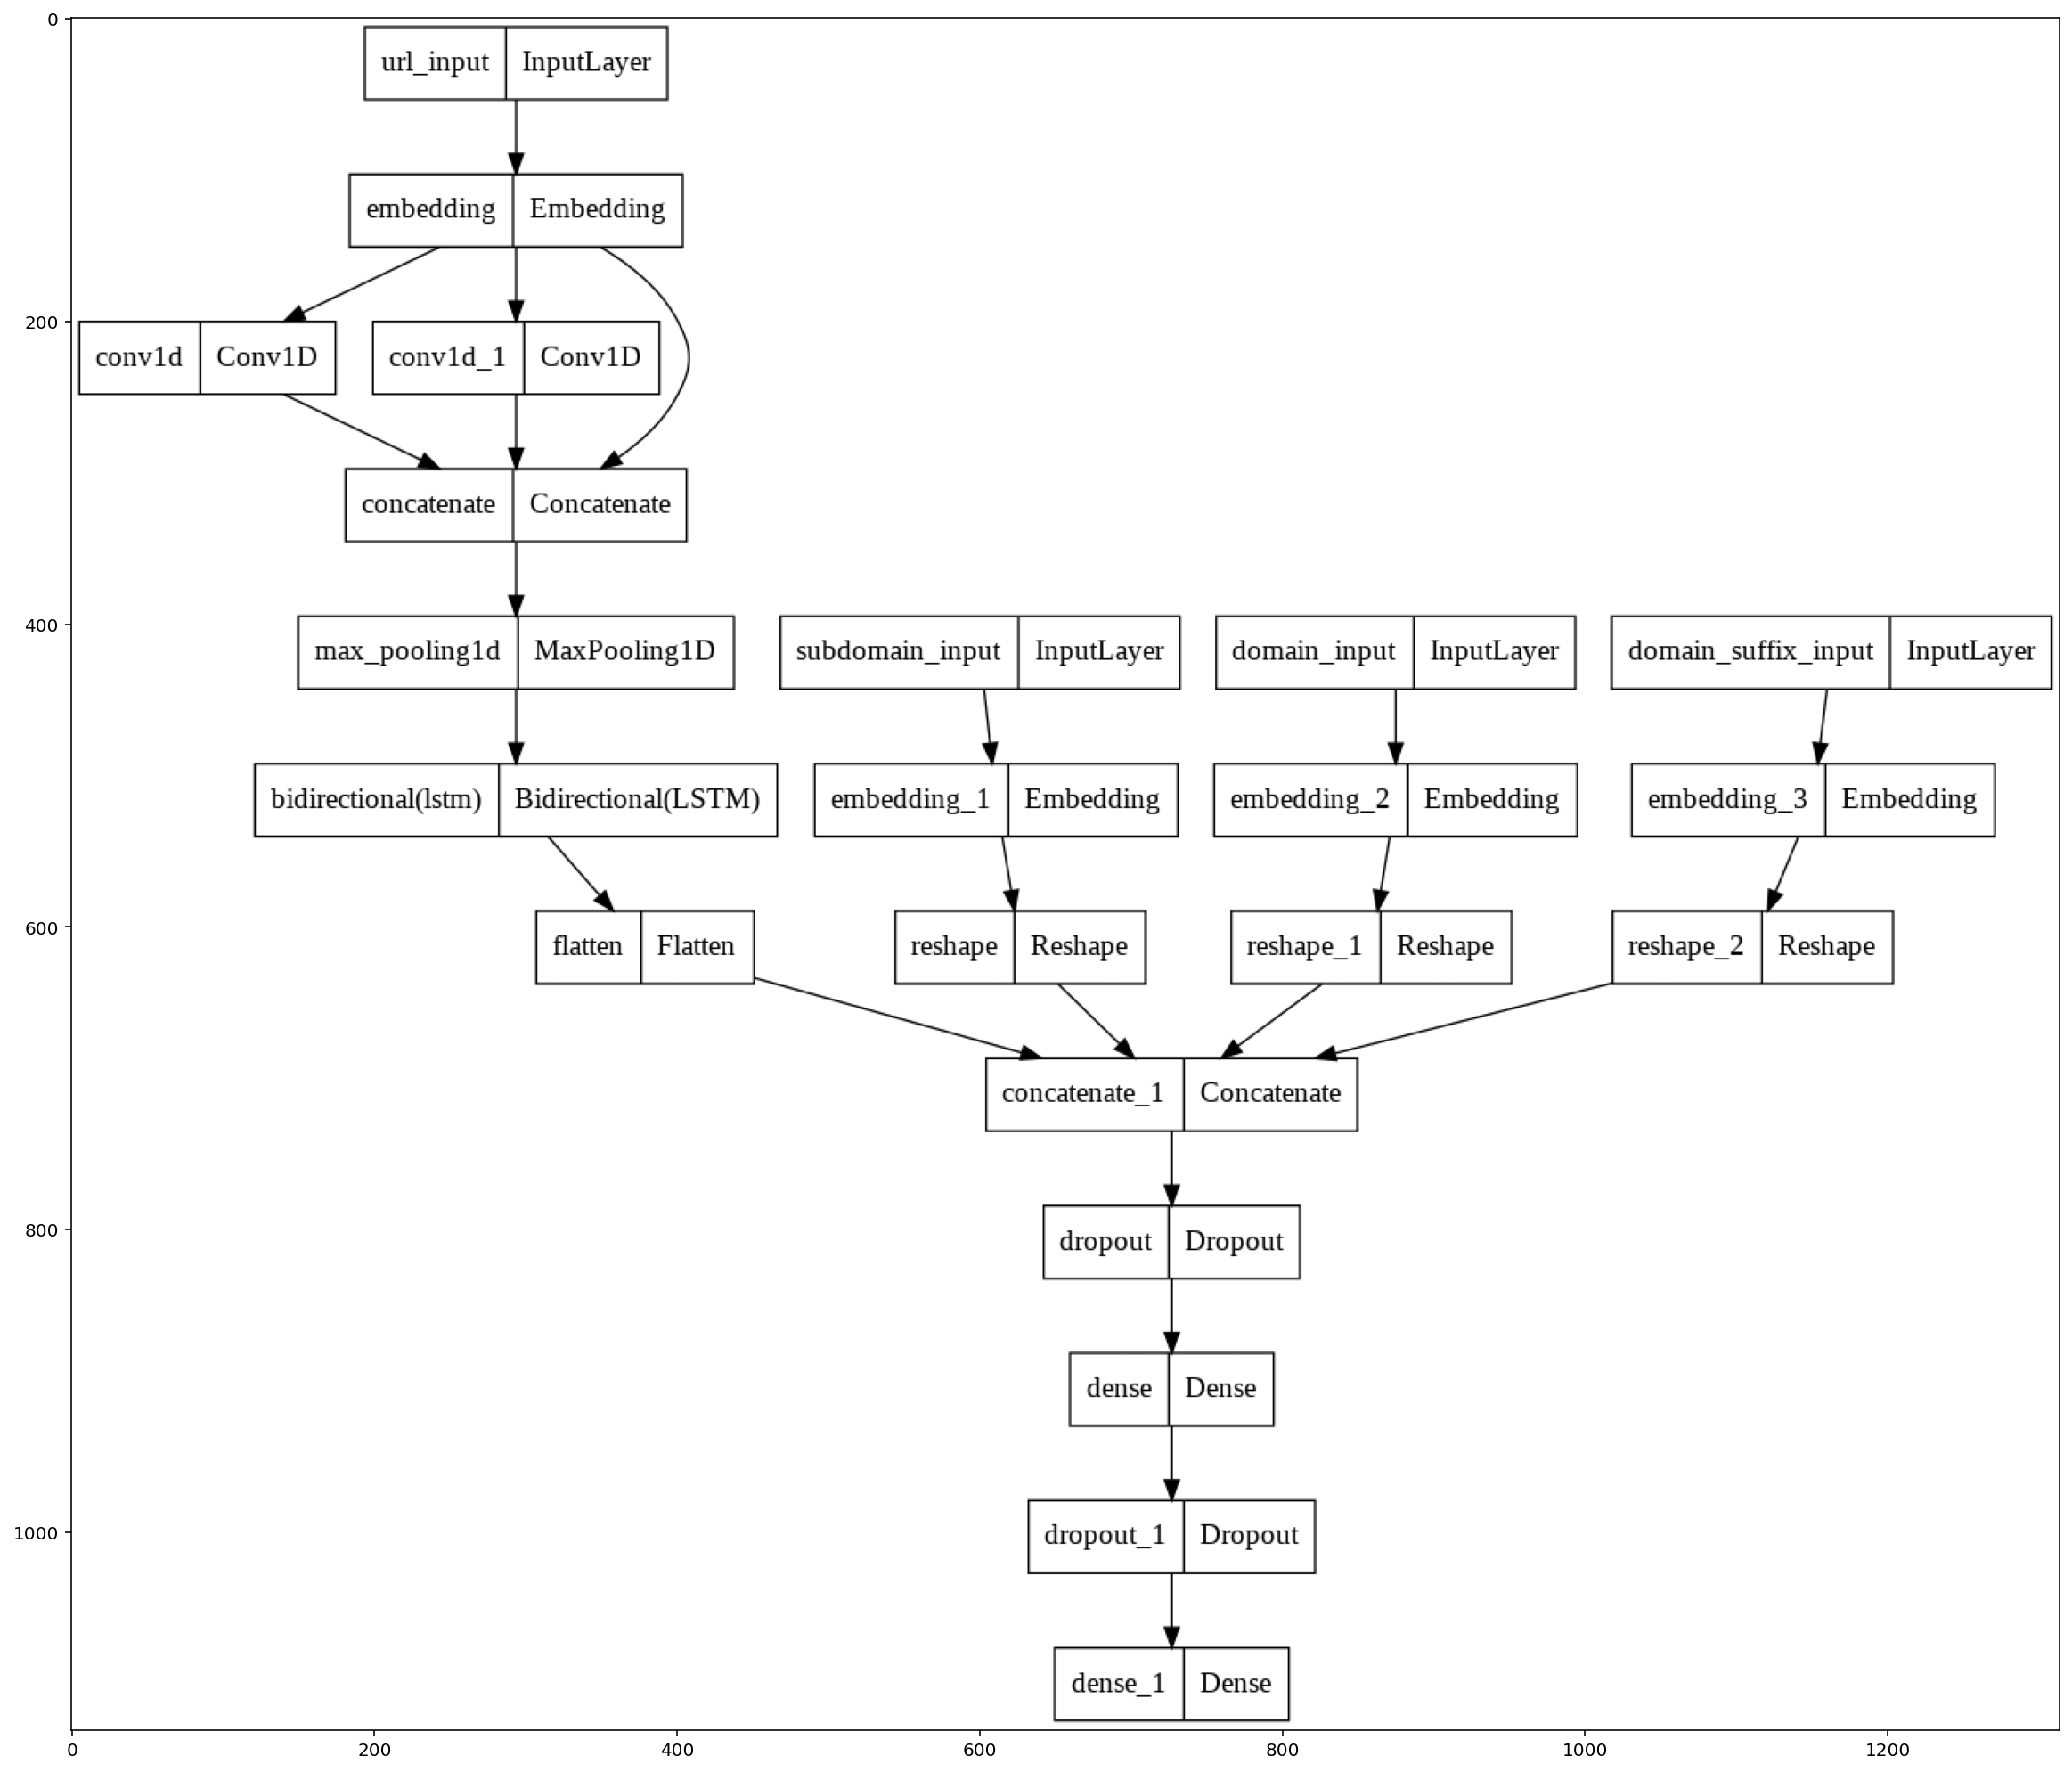

In [ ]:
# show model architecture
plot_model(model, to_file='model.png')
model_image = mpimg.imread('model.png')
plt.figure(figsize=(20, 20))
plt.imshow(model_image)
plt.show()

train_data.columns

In [ ]:
# model training
early_stopping = [EarlyStopping(monitor='val_precision', patience=12, restore_best_weights=True, mode='max')]
history = model.fit(train_x, train_y, batch_size=64, epochs=40, verbose=1, validation_data=(val_x,val_y), shuffle=True, callbacks=early_stopping)
model.save('model.h5')

Epoch 1/15
5256/5256 [==============================] - 116s 19ms/step - loss: 0.1147 - precision: 0.9189 - recall: 0.8390 - val_loss: 0.0620 - val_precision: 0.9757 - val_recall: 0.8979
Epoch 2/15
5256/5256 [==============================] - 94s 18ms/step - loss: 0.0479 - precision: 0.9668 - recall: 0.9412 - val_loss: 0.0391 - val_precision: 0.9772 - val_recall: 0.9502
Epoch 3/15
5256/5256 [==============================] - 92s 17ms/step - loss: 0.0271 - precision: 0.9813 - recall: 0.9679 - val_loss: 0.0362 - val_precision: 0.9771 - val_recall: 0.9592
Epoch 4/15
5256/5256 [==============================] - 94s 18ms/step - loss: 0.0181 - precision: 0.9883 - recall: 0.9797 - val_loss: 0.0360 - val_precision: 0.9872 - val_recall: 0.9473
Epoch 5/15
5256/5256 [==============================] - 92s 17ms/step - loss: 0.0135 - precision: 0.9918 - recall: 0.9848 - val_loss: 0.0435 - val_precision: 0.9906 - val_recall: 0.9355
Epoch 6/15
5256/5256 [==============================] - 93s 18ms/step

In [ ]:
from tensorflow.keras.models import  model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


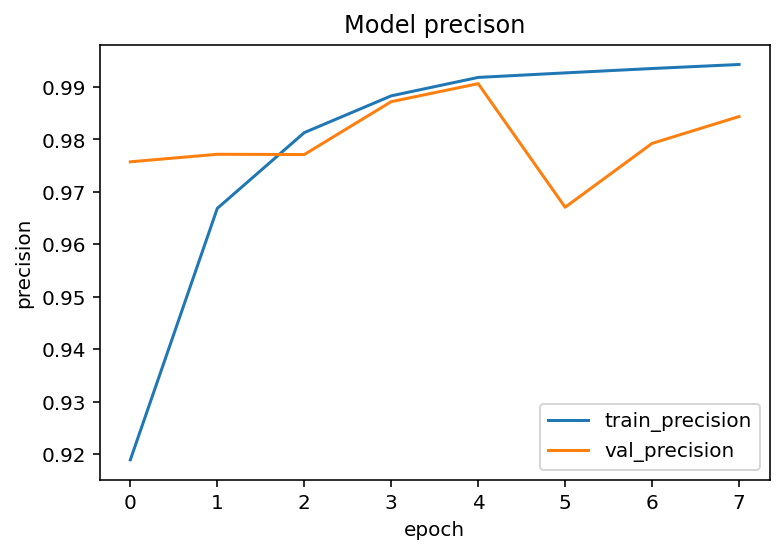

In [ ]:
# plot the training artifacts
import matplotlib.pyplot as plt
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precison')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train_precision','val_precision'], loc = 'lower right')
plt.show()

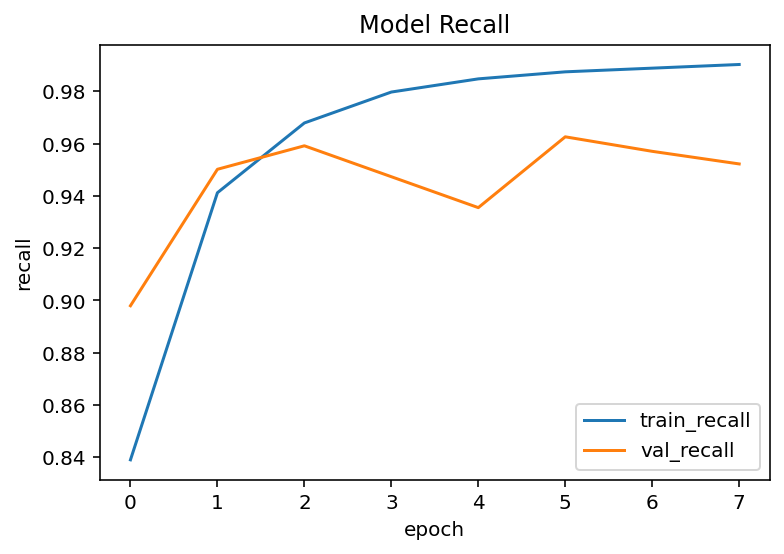

In [ ]:
# plot the training artifacts
import matplotlib.pyplot as plt
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train_recall','val_recall'], loc = 'lower right')
plt.show()

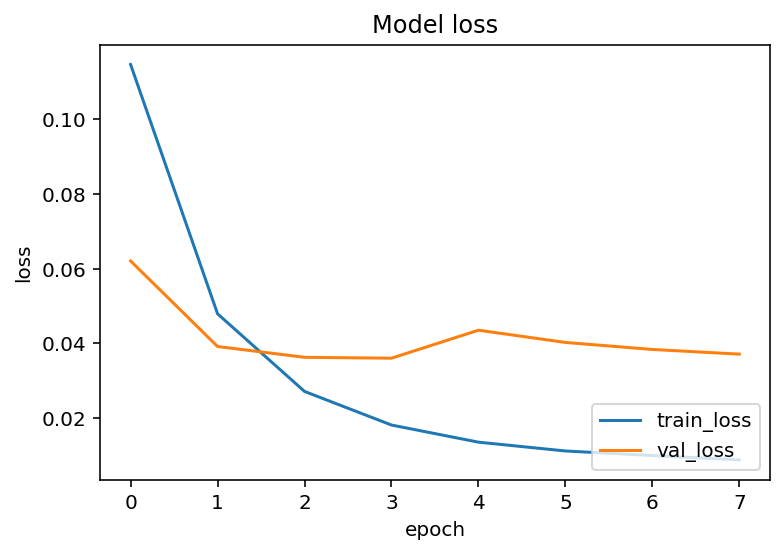

In [ ]:
# plot the training artifacts
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'lower right')
plt.show()

In [ ]:
fig = make_subplots(3, 1, subplot_titles=('loss', 'precision', 'recall'))

for index, key in enumerate(['loss', 'precision', 'recall']):
    # train score
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history[key]))),
        y=history.history[key],
        mode='lines+markers',
        name=key
    ), index + 1, 1)
    
    # val score
    fig.add_trace(go.Scatter(
        x=list(range(len(history.history[f'val_{key}']))),
        y=history.history[f'val_{key}'],
        mode='lines+markers',
        name=f'val {key}'
    ), index + 1, 1)

fig.show()

In [ ]:
fig = make_subplots(3, 1, subplot_titles=('loss', 'precision', 'recall'))

val_x = [val_seq, val_data['subdomain'], val_data['domain'], val_data['domain_suffix']]
val_y = val_data['label'].values

val_pred = model.predict(val_x)
val_pred = np.where(val_pred[:, 0] >= 0.5, 1, 0)



2628/2628 [==============================] - 15s 5ms/step


In [ ]:
print(f'Validation Data:\n{val_data.label.value_counts()}')
print(f'\n\nConfusion Matrix:\n{confusion_matrix(val_y, val_pred)}')
print(f'\n\nClassification Report:\n{classification_report(val_y, val_pred)}')


Validation Data:
0    68964
1    15129
Name: label, dtype: int64


Confusion Matrix:
[[68830   134]
 [  976 14153]]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     68964
           1       0.99      0.94      0.96     15129

    accuracy                           0.99     84093
   macro avg       0.99      0.97      0.98     84093
weighted avg       0.99      0.99      0.99     84093



In [ ]:
cr=classification_report(val_y, val_pred)

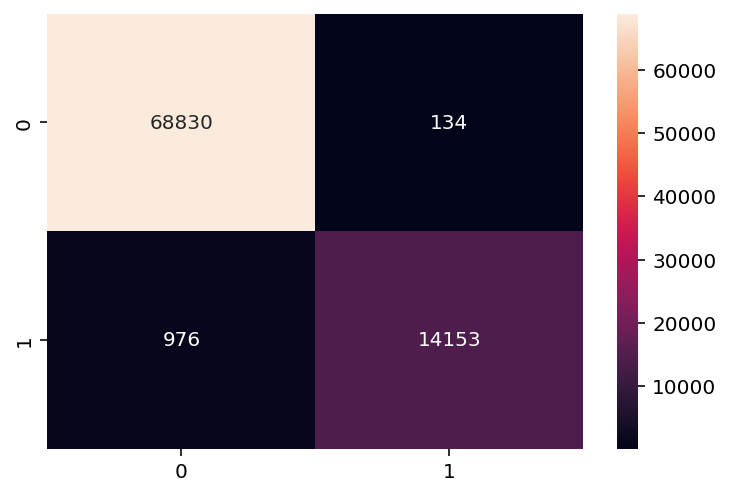

In [ ]:
import seaborn as sns
cm= confusion_matrix(val_y, val_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    
    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score','Support']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 10
    figure_height = len(class_names) + 3
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.show()



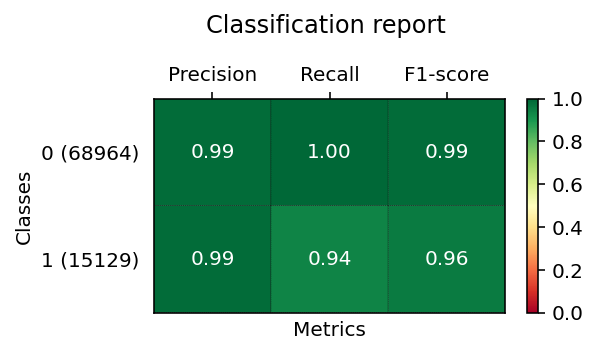

In [ ]:
plot_classification_report(cr)

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Add, BatchNormalization, Activation, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
model2 = keras.Sequential([
    layers.Dense(512, activation='relu',kernel_initializer='he_normal',input_shape=[336371,11]),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu',kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='tanh',kernel_initializer='glorot_uniform'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='tanh',kernel_initializer='glorot_uniform'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='tanh',kernel_initializer='glorot_uniform'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='tanh',kernel_initializer='glorot_uniform'),
    layers.Dropout(0.5),
    layers.Dense(1,activation='sigmoid'),
])
model2.summary()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 336371, 512)       6144      
                                                                 
 dropout_2 (Dropout)         (None, 336371, 512)       0         
                                                                 
 dense_3 (Dense)             (None, 336371, 512)       262656    
                                                                 
 dropout_3 (Dropout)         (None, 336371, 512)       0         
                                                                 
 dense_4 (Dense)             (None, 336371, 512)       262656    
                                                                 
 dropout_4 (Dropout)         (None, 336371, 512)       0         
                                                                 
 dense_5 (Dense)             (None, 336371, 512)       2

In [ ]:
train_X.shape()

NameError: ignored

In [ ]:
# model training
early_stopping = [EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max')]
history = model2.fit(train_x, train_y, batch_size=64, epochs=25, verbose=1, validation_data=(val_x,val_y), shuffle=True, callbacks=early_stopping)

Epoch 1/25


ValueError: ignored

In [ ]:
for data in (data,train_data,val_data):
  data['count-'] = data['url'].apply(lambda i: i.count('-'))
  data['count@'] = data['url'].apply(lambda i: i.count('@'))
  data['count?'] = data['url'].apply(lambda i: i.count('?'))
  data['count%'] = data['url'].apply(lambda i: i.count('%'))
  data['count%'] = data['url'].apply(lambda i: i.count('%'))
  data['count='] = data['url'].apply(lambda i: i.count('='))
  data['count-http'] = data['url'].apply(lambda i : i.count('http'))
  data['count-https'] = data['url'].apply(lambda i : i.count('https'))
  data['count-www'] = data['url'].apply(lambda i: i.count('www'))
  data['count-digits']= data['url'].apply(lambda i: digit_count(i))
  data['count-letters']= data['url'].apply(lambda i: letter_count(i))
  data['count_dir'] = data['url'].apply(lambda i: no_of_dir(i))




In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

In [ ]:
input_layer_2=layers.Input(shape=(11,))
#numeric_input_layer=layers.Input(shape=(numeric_features, ),name='numeric_input')
#input_layer_2.append(numeric_input_layer)
#model2 = layers.Conv1D(64, 3, padding='same', activation='elu')(input_layer_2)
model2=layers.LSTM(16,return_sequences=True,input_shape=(11, ))(input_layer_2)
model2=layers.Dense(10, activation='relu')(model2)
output_layer_2=layers.Dense(1,activation='sigmoid')(model2)
model2=Model(inputs=input_layer_2,outputs=output_layer_2)
# summarize layers
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
print(model2.summary())
